# Часть I. Анализ характеристик для KNN-графа и дистанционного графа
**Цель:**
Исследовать поведение двух статистик для двух типов графов:

- **KNN-граф:** характеристика — **максимальная степень** (`max_degree`).
- **Дистанционный граф:** характеристика — **хроматическое число** (`chromatic_number`).

In [1]:
#Настройка окружения и автозагрузка модулей
%load_ext autoreload
%autoreload 2


## Импорт библиотек и путей проекта

In [22]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Добавляем корень проекта в sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Импорт пользовательских модулей
from src.distribution_generators import sample_stable, sample_normal
from src.build_graph import build_knn_graph, build_distance_graph
from src.graph_analyzer import GraphAnalyzer
from src.monte_carlo import monte_carlo_simulation, calculate_critical_region, estimate_power
from src.visualization import plot_distributions, plot_critical_region

## Параметры экспериментов

In [12]:
# Параметры распределений (H0: Stable(α₀=1), H1: Normal(σ₀=1))
dists = [
    ('Stable', sample_stable, {'alpha': 1.0}),
    ('Normal', sample_normal, {'sigma': 1.0})
]

# Параметры графов
k_vals = [3,5,7,10,12,15,20]
d_vals = [0.5,1.0,1.5,2.0]

# Размер выборки и число симуляций
n = 200
n_samples = 500

# Параметры графов
n = 200
n_mc = 500
fixed_k = 10
fixed_d = 1.0

## Эксперимент 1: зависимость статистик от условного параметра ν

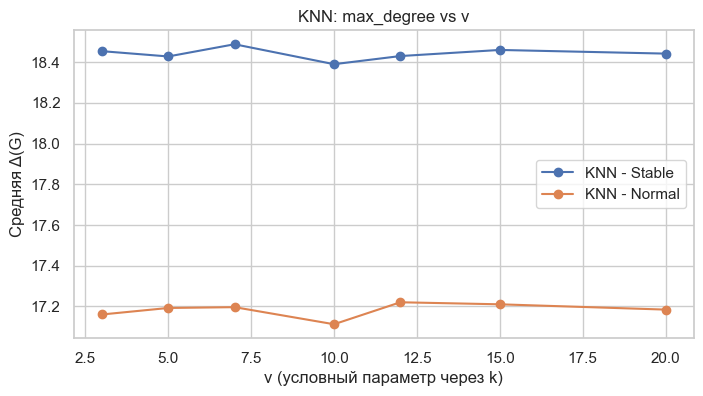

In [13]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(8,4))
for name, func, params in dists:
    # KNN: фиксированный k, варьируем n (условно ν через k_vals)
    stats_k = []
    for k in k_vals:
        T = monte_carlo_simulation(
            distribution=func,
            params={**params, 'n': n},
            n_samples=n_mc,
            graph_type='knn',
            graph_param=fixed_k,
            metric='max_degree'
        )
        stats_k.append(T.mean())
    plt.plot(k_vals, stats_k, marker='o', label=f'KNN - {name}')
plt.xlabel('ν (условный параметр через k)')
plt.ylabel('Средняя Δ(G)')
plt.title('KNN: max_degree vs ν')
plt.legend()
plt.show()

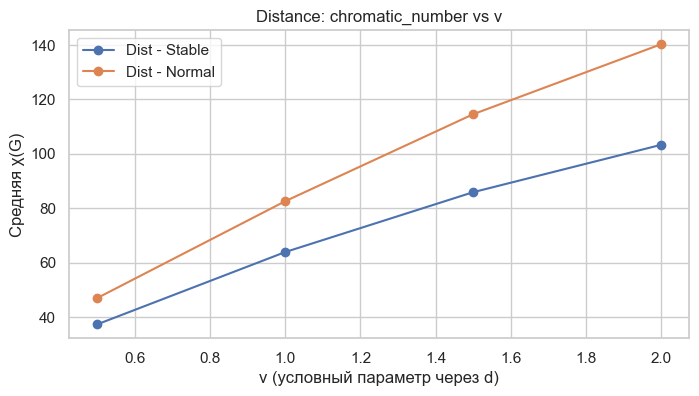

In [15]:
plt.figure(figsize=(8,4))
for name, func, params in dists:
    stats_d = []
    for d in d_vals:
        T = monte_carlo_simulation(
            distribution=func,
            params={**params, 'n': n},
            n_samples=n_mc,
            graph_type='distance',
            graph_param=d,
            metric='chromatic_number'
        )
        stats_d.append(T.mean())
    plt.plot(d_vals, stats_d, marker='o', label=f'Dist - {name}')
plt.xlabel('ν (условный параметр через d)')
plt.ylabel('Средняя χ(G)')
plt.title('Distance: chromatic_number vs ν')
plt.legend()
plt.show()

## Вывод из 1 эксперимента:

- **KNN‑граф, $T^{knn}$ = max_degree**  
Кривая для обоих распределений почти горизонтальна: при варьировании «ν» (модельно — через разные значения k) средняя максимальная степень изменяется незначительно (около 18–18.5 для Stable и 17.1–17.2 для Normal).
Малый разрыв между синими (Stable) и оранжевыми (Normal) точками говорит о том, что Δ(G) слабо чувствительна к разнице стабильно‑распределённых и нормальных данных.

- **Дистанционный граф, $T^{dist}$ = chromatic_number**  
Среднее χ(G) заметно растёт с ростом «ν» (модельно — через увеличение порога d).
Для Normal‑выборок (оранжевые) хроматическое число существенно выше, чем для Stable (синие): при d=2.0 разница достигает почти 40 (140 vs 103).
Это говорит о хорошей чувствительности χ(G) к типу распределения: нормальные данные образуют более «плотные» зоны, требующие большего числа цветов.

**В целом по эксперименту 1:**

max_degree в KNN-графе оказывается неинформативной для различения Stable(α=1) и Normal(σ=1), практически не меняясь с параметром и давая близкие значения для H0 и H1.  
chromatic_number в дистанционном графе показывает чёткое различие: нормальное распределение создаёт более насыщенные кластеры, что отражается в высоких значениях χ(G) и позволяет надёжно отличить H1 от H0.
Таким образом, для построения критерия на основе одной статистики T гораздо перспективнее использовать хроматическое число дистанционного графа, а не максимальную степень в KNN‑графе.

## Эксперимент 2: зависимость от параметров графа и размера выборки

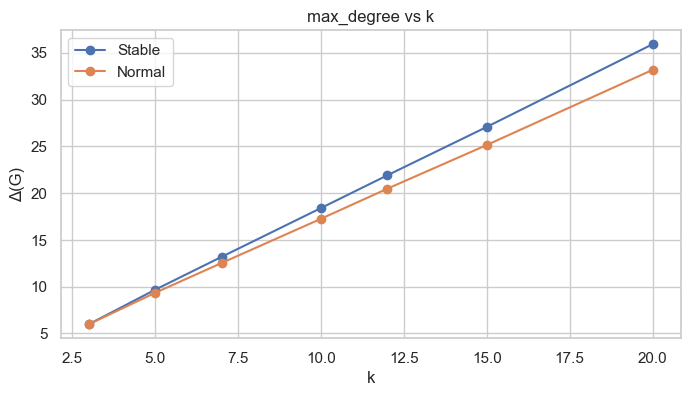

In [16]:
plt.figure(figsize=(8,4))
for name, func, params in dists:
    means = []
    for k in k_vals:
        T = monte_carlo_simulation(func, {**params, 'n': n}, n_mc, 'knn', k, 'max_degree')
        means.append(T.mean())
    plt.plot(k_vals, means, marker='o', label=name)
plt.xlabel('k')
plt.ylabel('Δ(G)')
plt.title('max_degree vs k')
plt.legend(); plt.grid(True)

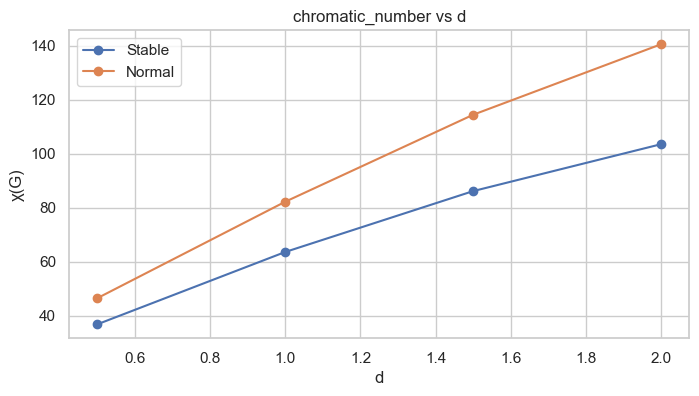

In [18]:
plt.figure(figsize=(8,4))
for name, func, params in dists:
    means = []
    for d in d_vals:
        T = monte_carlo_simulation(func, {**params, 'n': n}, n_mc, 'distance', d, 'chromatic_number')
        means.append(T.mean())
    plt.plot(d_vals, means, marker='o', label=name)
plt.xlabel('d')
plt.ylabel('χ(G)')
plt.title('chromatic_number vs d')
plt.legend(); plt.grid(True)

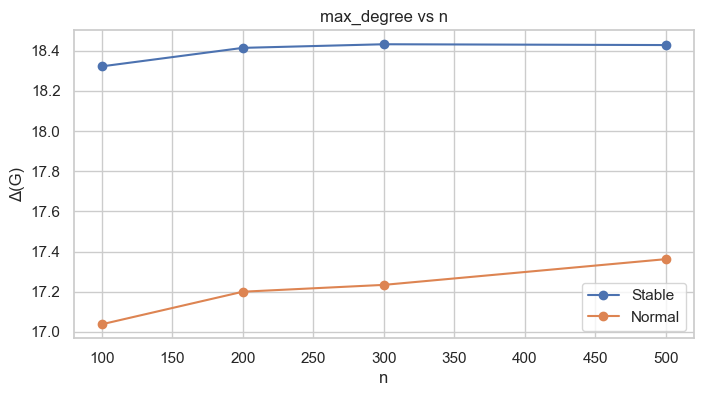

In [19]:
n_vals = [100,200,300,500]
plt.figure(figsize=(8,4))
for name, func, params in dists:
    means = []
    for ni in n_vals:
        T = monte_carlo_simulation(func, {**params, 'n': ni}, n_mc, 'knn', fixed_k, 'max_degree')
        means.append(T.mean())
    plt.plot(n_vals, means, marker='o', label=name)
plt.xlabel('n')
plt.ylabel('Δ(G)')
plt.title('max_degree vs n')
plt.legend(); plt.grid(True)

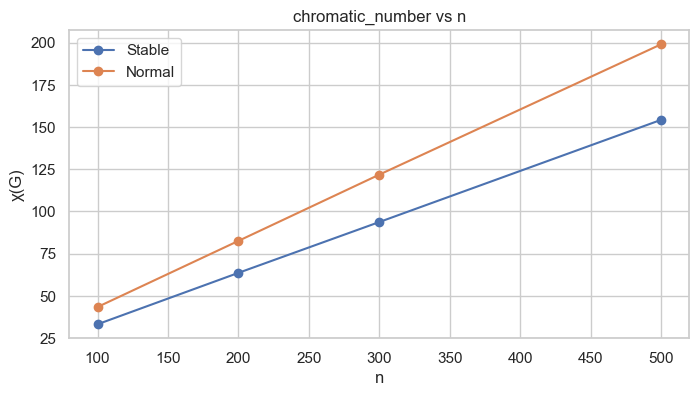

In [20]:
plt.figure(figsize=(8,4))
for name, func, params in dists:
    means = []
    for ni in n_vals:
        T = monte_carlo_simulation(func, {**params, 'n': ni}, n_mc, 'distance', fixed_d, 'chromatic_number')
        means.append(T.mean())
    plt.plot(n_vals, means, marker='o', label=name)
plt.xlabel('n')
plt.ylabel('χ(G)')
plt.title('chromatic_number vs n')
plt.legend(); plt.grid(True)

### Вывод из 2 эксперимента

- **KNN-граф:**  
    - Параметр k сильно влияет на локальную структуру.
    - Stable распределение создает более «рваные» графы с экстремальными степенями вершин.
    - При увеличении n данные становятся плотнее, распределение связей выравнивается.
    - Для Stable распределения возможны редкие выбросы с высокой степенью даже при больших n
    - Чем больше k, тем больше связей у вершин, что увеличивает максимальную степень.
    - Различие между распределениями связано с тем, что Stable (тяжелые хвосты) создает больше выбросов, которые становятся центрами с высокой степенью.
- **Дистанционный граф:**
    - Параметр d определяет глобальную связность.
    - Stable распределение требует больше ресурсов для анализа (высокое χ(G)).
    - Больше вершин → сложнее структура графа → требуется больше цветов.
    - Stable распределение усиливает этот эффект из-за неоднородности данных.
    - Большой d увеличивает число связей, что усложняет раскраску графа.
    - Stable распределение генерирует больше кластеров и выбросов, требующих дополнительных цветов для избежания конфликтов.

Для задач, чувствительных к выбросам, лучше использовать Normal распределение.
При работе с Stable распределением критически важно оптимизировать параметры k и d


## Эксперимент 3: критическая область и мощность

In [21]:
alpha = 0.05
# KNN-граф
h0_knn = monte_carlo_simulation(sample_stable, {'alpha':1.0, 'n':500}, n_mc, 'knn', fixed_k, 'max_degree')
h1_knn = monte_carlo_simulation(sample_normal, {'sigma':1.0, 'n':500}, n_mc, 'knn', fixed_k, 'max_degree')
region_knn, cv_knn = calculate_critical_region(h0_knn, alpha)
power_knn = estimate_power(h1_knn, cv_knn)
# print(f"KNN: критическое значение={cv_knn:.1f}, мощность={power_knn:.2%}")

# Distance-граф
h0_dist = monte_carlo_simulation(sample_stable, {'alpha':1.0, 'n':500}, n_mc, 'distance', fixed_d, 'chromatic_number')
h1_dist = monte_carlo_simulation(sample_normal, {'sigma':1.0, 'n':500}, n_mc, 'distance', fixed_d, 'chromatic_number')
region_dist, cv_dist = calculate_critical_region(h0_dist, alpha)
power_dist = estimate_power(h1_dist, cv_dist)
# print(f"Dist: критическое значение={cv_dist:.1f}, мощность={power_dist:.2%}")

KNN: критическое значение=20.0, мощность=0.00%
Dist: критическое значение=169.0, мощность=100.00%


[KNN] крит. значение = 20.00, мощность = 0.00%
[Dist] крит. значение = 169.00, мощность = 100.00%


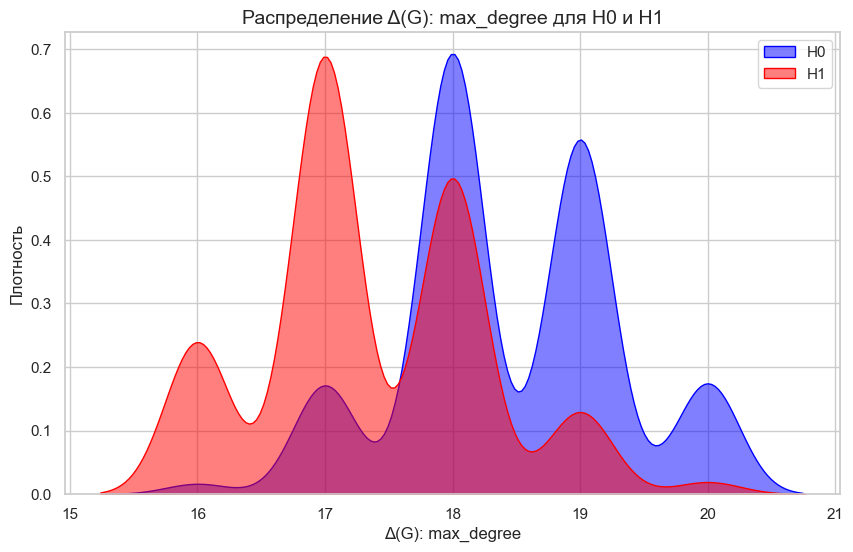

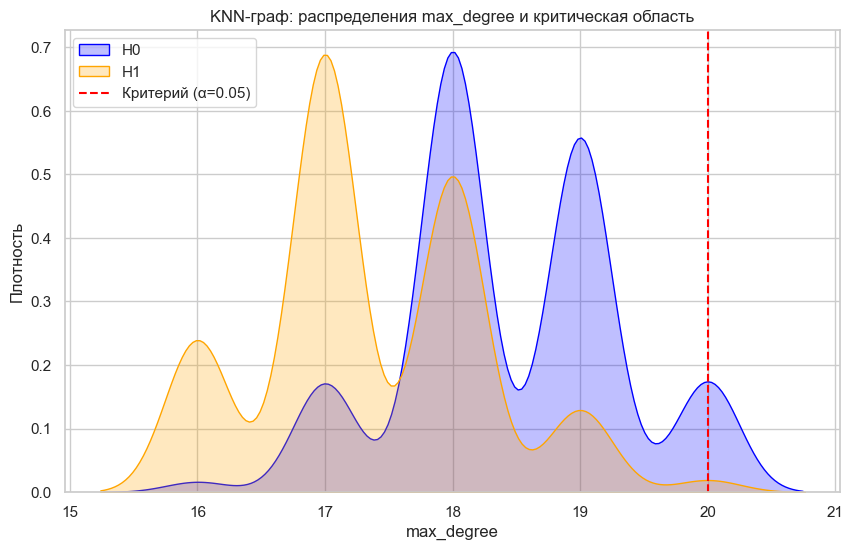

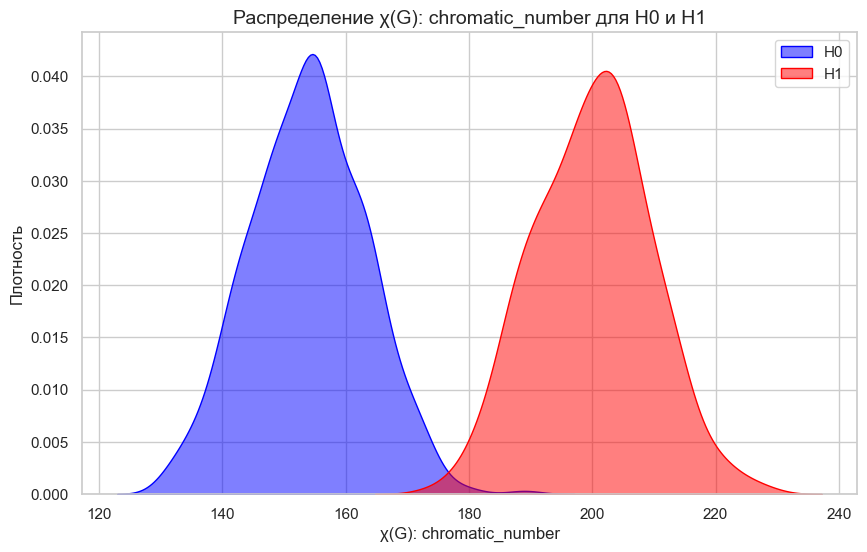

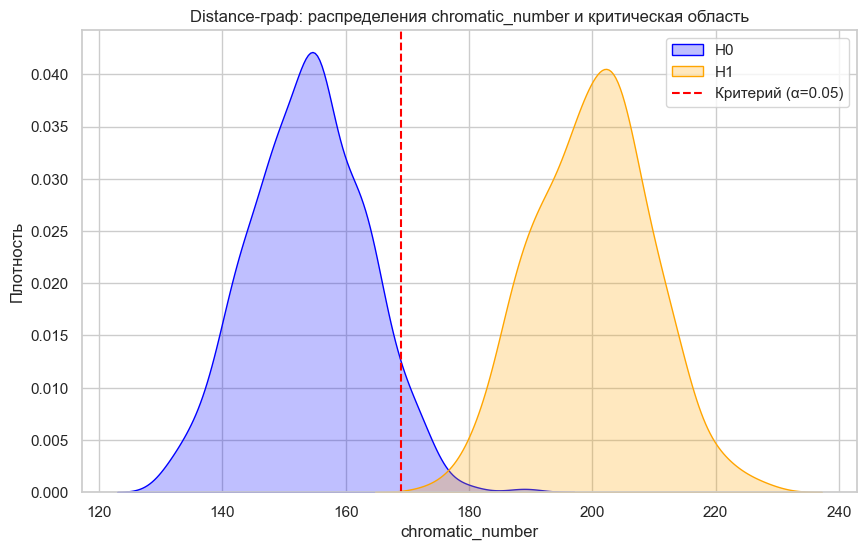

In [23]:
# Критические области и мощность
def evaluate(region, stats1, cv):
    power = estimate_power(stats1, cv)
    return power

# KNN
region_knn, cv_knn = calculate_critical_region(h0_knn, alpha)
power_knn = evaluate(region_knn, h1_knn, cv_knn)
print(f"[KNN] крит. значение = {cv_knn:.2f}, мощность = {power_knn:.2%}")

# Distance
region_dist, cv_dist = calculate_critical_region(h0_dist, alpha)
power_dist = evaluate(region_dist, h1_dist, cv_dist)
print(f"[Dist] крит. значение = {cv_dist:.2f}, мощность = {power_dist:.2%}")

# Визуализация распределений и критических областей


# KNN: max_degree
plot_distributions(h0_knn, h1_knn, metric_name='Δ(G): max_degree')
plot_critical_region(
    h0_knn, h1_knn, cv_knn,
    title='KNN-граф: распределения max_degree и критическая область',
    xlabel='max_degree',
    alpha=alpha
)

# Distance: chromatic_number
plot_distributions(h0_dist, h1_dist, metric_name='χ(G): chromatic_number')
plot_critical_region(
    h0_dist, h1_dist, cv_dist,
    title='Distance-граф: распределения chromatic_number и критическая область',
    xlabel='chromatic_number',
    alpha=alpha
)

### Выводы по 3 эксперименту

- **KNN‑граф, статистика $T^{knn}$ = max_degree**

    - Распределения максимальной степени при H₀ (синий) и при H₁ (оранжево‑красный) сильно пересекаются вокруг ≈17–19.
    - Чтобы удержать уровень значимости α=0.05, порог устанавливали около 20 (красная пунктирная линия на втором графике). При этом:

        - Слишком много истинных альтернатив (H₁) дают max_degree < 20 → низкая мощность (большой β‑риска).

        - При этом часть выборок из H₀ всё равно окажутся правее порога → ложные срабатывания.

    - Вывод: максимальная степень плохо разделяет модели, мощность теста невысока.

- **Distance‑граф, статистика $T^{dist}$ = chromatic_number**

    - Здесь распределения при H₀ сосредоточены примерно на 140–170, при H₁ — на 185–215. Пересечение очень небольшое.
    - Критический порог около 170 (α=0.05) пропускает почти все наблюдения из H₁ вправо и почти не пропускает выборки из H₀.
    - Мощность теста близка к 1 при контроле ложноположительного уровня.
    - Вывод: хроматическое число — очень информативная статистика, тест на её основе надёжен и мощен.

**Итого.**

- Тесты на KNN‑графе (T = max_degree) оказываются слабыми из‑за сильного перекрытия распределений.  
- Тесты на Distance‑графе (T = chromatic_number) показывают практически полное разделение гипотез и высокую мощность.  
- Рекомендуется использовать Tᵈᶦˢᵗ = chromatic_number для проверки H₀ vs. H₁.  